In [18]:
import os
import time
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.spatial import ConvexHull
from numpy.linalg import svd, det

import pinocchio as pin
from pinocchio import SE3, buildGeomFromUrdf
from pinocchio.robot_wrapper import RobotWrapper
from pinocchio.visualize import MeshcatVisualizer
from pinocchio import CollisionPair

import meshcat
import meshcat.geometry as g
from meshcat.transformations import scale_matrix

from hppfcl import CollisionObject
import pyvista as pv
pv.set_jupyter_backend("trame")

import casadi as ca
import pinocchio.casadi as cpin
import pycapacity.robot as pycap
import numpy as np
from hppfcl import Box
from collections import namedtuple

In [19]:
# URDF paths
# jvrc1_urdf = "/home/lmoussafir/workspace/src/catkin_data_ws/src/mc_rtc_data/jvrc_description/urdf/jvrc1.urdf"
jvrc1_urdf ="/home/lmoussafir/Documents/SchaefflerEnv/Tests/jvrc_description-master/urdf/jvrc1.urdf"
palette_urdf = "/home/lmoussafir/workspace/install/share/mc_rtc/palette_box/urdf/palette_box.urdf"
feeder_urdf = "/home/lmoussafir/workspace/install/share/mc_rtc/part_feeder/urdf/part_feeder.urdf"

# Sampling resolution (per joint)
n_points = 4
exploration_mode = "random"  # "grid" or "random"
num_samples = 5000 
ENABLE_RIGHT_ARM = True
ENABLE_LEFT_ARM = False 
include_torso_pitch = False  # ajoute le DOF de pitch du torse
include_torso_roll = False  # ajoute le DOF de roll du torse
# Transformation of objects in the world frame
T_palette = SE3.Identity()
T_palette.translation = np.array([0.6, -0.3, -0.3])
T_feeder = SE3.Identity()
T_feeder.translation = np.array([0.6, 0.3, -0.5])
#Visualization
SHOW_POINT_CLOUD = False
SHOW_CONVEX_HULL = True
# List of external collision objects (palette + feeder)
external_object_names = [
    "part_feeder_convex_0",
    "part_feeder_convex_1",
    "part_feeder_convex_2",
    "part_feeder_convex_3",
    "part_feeder_convex_4",
    "base_link_0",
    "base_link_1",
    "base_link_2",
    "base_link_3",
    "base_link_4"
]

# List of robot convex objects for collision checks
robot_convex_name = [
    'L_ELBOW_P_S_0', 'L_ELBOW_Y_S_0', 'L_SHOULDER_P_S_0', 'L_SHOULDER_Y_S_0',
    'L_WRIST_Y_S_0', 'NECK_P_S_0', 'NECK_Y_S_0', 'R_ELBOW_P_S_0',
    'R_ELBOW_Y_S_0', 'R_SHOULDER_P_S_0', 'R_SHOULDER_Y_S_0', 'R_WRIST_Y_S_0',
    'WAIST_R_S_0', 'WAIST_Y_S_0','right_arm_m1_0',
     'right_arm_shoulder_l1_0',
     'right_arm_m2_0',
     'right_arm_shoulder_l2_0',
     'right_arm_m3_0',
     'right_arm_elbow_l1_0',
     'right_arm_m4_0',
     'right_arm_elbow_l2_0',
     'right_arm_m5_0',
     'right_arm_wrist_l1_0',
     'right_arm_m6_0',
     'right_arm_wrist_l2_0',
     'right_arm_wrist_l3_0',
     'right_arm_eef_0'
]

# Effectors
frame_name_right = "R_WRIST_Y"
frame_name_left = "L_WRIST_Y"

# Joint names per arm
joint_names_right = [
    "R_SHOULDER_P", "R_SHOULDER_R", "R_SHOULDER_Y",
    "R_ELBOW_P", "R_ELBOW_Y", "R_WRIST_R", "R_WRIST_Y"
]
joint_names_left = [
    "L_SHOULDER_P", "L_SHOULDER_R", "L_SHOULDER_Y",
    "L_ELBOW_P", "L_ELBOW_Y", "L_WRIST_R", "L_WRIST_Y"
]


In [20]:
# Load robot model
jvrc1 = RobotWrapper.BuildFromURDF(jvrc1_urdf)
q0 = pin.neutral(jvrc1.model)

# Load external objects
palette = RobotWrapper.BuildFromURDF(palette_urdf)
feeder = RobotWrapper.BuildFromURDF(feeder_urdf)

# Merge external objects into robot collision/visual model
for obj in palette.collision_model.geometryObjects:
    new_obj = obj.copy()
    new_obj.placement = T_palette * obj.placement
    jvrc1.collision_model.addGeometryObject(new_obj)
for obj in feeder.collision_model.geometryObjects:
    new_obj = obj.copy()
    new_obj.placement = T_feeder * obj.placement
    jvrc1.collision_model.addGeometryObject(new_obj)
for obj in palette.visual_model.geometryObjects:
    new_obj = obj.copy()
    new_obj.placement = T_palette * obj.placement
    jvrc1.visual_model.addGeometryObject(new_obj)
for obj in feeder.visual_model.geometryObjects:
    new_obj = obj.copy()
    new_obj.placement = T_feeder * obj.placement
    jvrc1.visual_model.addGeometryObject(new_obj)

In [21]:
viz = MeshcatVisualizer(jvrc1.model, jvrc1.collision_model, jvrc1.visual_model)
viz.initViewer(loadModel=True)
viz.display(q0)

# Define pairs to add for self-collision filtering
def find_geom_index_by_name(cmodel, name, allow_partial_suffix=False):
    for i, obj in enumerate(cmodel.geometryObjects):
        if obj.name == name:
            return i
    if allow_partial_suffix:
        for i, obj in enumerate(cmodel.geometryObjects):
            if obj.name.startswith(name):
                print(f"[INFO] Partial match: '{name}' matched '{obj.name}'")
                return i
    raise ValueError(f"[ERROR] Object '{name}' not found in collision_model")

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [22]:
viz.viewer.jupyter_cell()


In [23]:
# Define self-collision pairs (modifiable si nécessaire)
pairs_to_add = [
    ("NECK_P_S_0", "WAIST_Y_S_0"), ("NECK_P_S_0", "WAIST_R_S_0"),
    ("NECK_P_S_0", "R_SHOULDER_P_S_0"), ("NECK_P_S_0", "R_SHOULDER_Y_S_0"),
    ("NECK_P_S_0", "R_ELBOW_P_S_0"), ("NECK_P_S_0", "R_ELBOW_Y_S_0"),
    ("NECK_P_S_0", "R_WRIST_Y_S_0"),
    ("NECK_Y_S_0", "R_SHOULDER_P_S_0"), ("NECK_Y_S_0", "R_SHOULDER_Y_S_0"),
    ("NECK_Y_S_0", "R_ELBOW_P_S_0"), ("NECK_Y_S_0", "R_ELBOW_Y_S_0"), ("NECK_Y_S_0", "R_WRIST_Y_S_0"),
    ("WAIST_Y_S_0", "R_SHOULDER_P_S_0"), ("WAIST_Y_S_0", "R_SHOULDER_Y_S_0"),
    ("WAIST_Y_S_0", "R_ELBOW_P_S_0"), ("WAIST_Y_S_0", "R_ELBOW_Y_S_0"), ("WAIST_Y_S_0", "R_WRIST_Y_S_0"),
    ("WAIST_R_S_0", "R_SHOULDER_Y_S_0"), ("WAIST_R_S_0", "R_ELBOW_P_S_0"), ("WAIST_R_S_0", "R_ELBOW_Y_S_0"), ("WAIST_R_S_0", "R_WRIST_Y_S_0"),
    ("R_SHOULDER_P_S_0", "R_ELBOW_P_S_0"), ("R_SHOULDER_P_S_0", "R_ELBOW_Y_S_0"), ("R_SHOULDER_P_S_0", "R_WRIST_Y_S_0"),
    ("R_SHOULDER_Y_S_0", "R_ELBOW_Y_S_0"), ("R_SHOULDER_Y_S_0", "R_WRIST_Y_S_0"),
    ("R_ELBOW_P_S_0", "R_WRIST_Y_S_0"),
    ("NECK_P_S_0", "L_SHOULDER_P_S_0"), ("NECK_P_S_0", "L_SHOULDER_Y_S_0"),
    ("NECK_P_S_0", "L_ELBOW_P_S_0"), ("NECK_P_S_0", "L_ELBOW_Y_S_0"), ("NECK_P_S_0", "L_WRIST_Y_S_0"),
    ("NECK_Y_S_0", "L_SHOULDER_P_S_0"), ("NECK_Y_S_0", "L_SHOULDER_Y_S_0"),
    ("NECK_Y_S_0", "L_ELBOW_P_S_0"), ("NECK_Y_S_0", "L_ELBOW_Y_S_0"), ("NECK_Y_S_0", "L_WRIST_Y_S_0"),
    ("WAIST_Y_S_0", "L_SHOULDER_P_S_0"), ("WAIST_Y_S_0", "L_SHOULDER_Y_S_0"),
    ("WAIST_Y_S_0", "L_ELBOW_P_S_0"), ("WAIST_Y_S_0", "L_ELBOW_Y_S_0"), ("WAIST_Y_S_0", "L_WRIST_Y_S_0"),
    ("WAIST_R_S_0", "L_SHOULDER_Y_S_0"), ("WAIST_R_S_0", "L_ELBOW_P_S_0"), ("WAIST_R_S_0", "L_ELBOW_Y_S_0"), ("WAIST_R_S_0", "L_WRIST_Y_S_0"),
    ("L_SHOULDER_P_S_0", "L_ELBOW_P_S_0"), ("L_SHOULDER_P_S_0", "L_ELBOW_Y_S_0"), ("L_SHOULDER_P_S_0", "L_WRIST_Y_S_0"),
    ("L_SHOULDER_Y_S_0", "L_ELBOW_Y_S_0"), ("L_SHOULDER_Y_S_0", "L_WRIST_Y_S_0"), ("L_ELBOW_P_S_0", "L_WRIST_Y_S_0")
]
pairs_to_add += [
    ("right_arm_m1_0", "right_arm_m2_0"),
    ("right_arm_m1_0", "right_arm_shoulder_l2_0"),
    ("right_arm_m1_0", "right_arm_m3_0"),
    ("right_arm_m1_0", "right_arm_elbow_l1_0"),
    ("right_arm_m1_0", "right_arm_m4_0"),
    ("right_arm_m1_0", "right_arm_elbow_l2_0"),
    ("right_arm_m1_0", "right_arm_m5_0"),
    ("right_arm_m1_0", "right_arm_wrist_l1_0"),
    ("right_arm_m1_0", "right_arm_m6_0"),
    ("right_arm_m1_0", "right_arm_wrist_l2_0"),
    ("right_arm_m1_0", "right_arm_m7_0"),
    ("right_arm_m1_0", "right_arm_wrist_l3_0"),

    ("right_arm_shoulder_l1_0", "right_arm_m3_0"),
    ("right_arm_shoulder_l1_0", "right_arm_elbow_l1_0"),
    ("right_arm_shoulder_l1_0", "right_arm_m4_0"),
    ("right_arm_shoulder_l1_0", "right_arm_elbow_l2_0"),
    ("right_arm_shoulder_l1_0", "right_arm_m5_0"),
    ("right_arm_shoulder_l1_0", "right_arm_wrist_l1_0"),
    ("right_arm_shoulder_l1_0", "right_arm_m6_0"),
    ("right_arm_shoulder_l1_0", "right_arm_wrist_l2_0"),
    ("right_arm_shoulder_l1_0", "right_arm_m7_0"),
    ("right_arm_shoulder_l1_0", "right_arm_wrist_l3_0"),

    ("right_arm_m2_0", "right_arm_m3_0"),
    ("right_arm_m2_0", "right_arm_elbow_l1_0"),
    ("right_arm_m2_0", "right_arm_m4_0"),
    ("right_arm_m2_0", "right_arm_elbow_l2_0"),
    ("right_arm_m2_0", "right_arm_m5_0"),
    ("right_arm_m2_0", "right_arm_wrist_l1_0"),
    ("right_arm_m2_0", "right_arm_m6_0"),
    ("right_arm_m2_0", "right_arm_wrist_l2_0"),
    ("right_arm_m2_0", "right_arm_m7_0"),
    ("right_arm_m2_0", "right_arm_wrist_l3_0"),


    ("right_arm_shoulder_l2_0", "right_arm_m4_0"),
    ("right_arm_shoulder_l2_0", "right_arm_elbow_l2_0"),
    ("right_arm_shoulder_l2_0", "right_arm_m5_0"),
    ("right_arm_shoulder_l2_0", "right_arm_wrist_l1_0"),
    ("right_arm_shoulder_l2_0", "right_arm_m6_0"),
    ("right_arm_shoulder_l2_0", "right_arm_wrist_l2_0"),
    ("right_arm_shoulder_l2_0", "right_arm_m7_0"),
    ("right_arm_shoulder_l2_0", "right_arm_wrist_l3_0"),

    ("right_arm_m3_0", "right_arm_m4_0"),
    ("right_arm_m3_0", "right_arm_elbow_l2_0"),
    ("right_arm_m3_0", "right_arm_m5_0"),
    ("right_arm_m3_0", "right_arm_wrist_l1_0"),
    ("right_arm_m3_0", "right_arm_m6_0"),
    ("right_arm_m3_0", "right_arm_wrist_l2_0"),
    ("right_arm_m3_0", "right_arm_m7_0"),
    ("right_arm_m3_0", "right_arm_wrist_l3_0"),

    ("right_arm_elbow_l1_0", "right_arm_m5_0"),
    ("right_arm_elbow_l1_0", "right_arm_wrist_l1_0"),
    ("right_arm_elbow_l1_0", "right_arm_m6_0"),
    ("right_arm_elbow_l1_0", "right_arm_wrist_l2_0"),
    ("right_arm_elbow_l1_0", "right_arm_m7_0"),
    ("right_arm_elbow_l1_0", "right_arm_wrist_l3_0"),

    ("right_arm_m4_0", "right_arm_m5_0"),
    ("right_arm_m4_0", "right_arm_wrist_l1_0"),
    ("right_arm_m4_0", "right_arm_m6_0"),
    ("right_arm_m4_0", "right_arm_wrist_l2_0"),
    ("right_arm_m4_0", "right_arm_m7_0"),
    ("right_arm_m4_0", "right_arm_wrist_l3_0"),


    ("right_arm_elbow_l2_0", "right_arm_m6_0"),
    ("right_arm_elbow_l2_0", "right_arm_wrist_l2_0"),
    ("right_arm_elbow_l2_0", "right_arm_m7_0"),
    ("right_arm_elbow_l2_0", "right_arm_wrist_l3_0"),

    ("right_arm_m5_0", "right_arm_m6_0"),
    ("right_arm_m5_0", "right_arm_wrist_l2_0"),
    ("right_arm_m5_0", "right_arm_m7_0"),
    ("right_arm_m5_0", "right_arm_wrist_l3_0"),


    ("right_arm_wrist_l1_0", "right_arm_m7_0"),
    ("right_arm_wrist_l1_0", "right_arm_wrist_l3_0"),

    ("right_arm_m6_0", "right_arm_m7_0"),
    ("right_arm_m6_0", "right_arm_wrist_l3_0"),


    ("right_arm_wrist_l2_0", "right_arm_eef_0"),

    ("NECK_Y_S_0", "right_arm_m1_0"),
    ("NECK_Y_S_0", "right_arm_shoulder_l1_0"),
    ("NECK_Y_S_0", "right_arm_m2_0"),
    ("NECK_Y_S_0", "right_arm_shoulder_l2_0"),
    ("NECK_Y_S_0", "right_arm_m3_0"),
    ("NECK_Y_S_0", "right_arm_elbow_l1_0"),
    ("NECK_Y_S_0", "right_arm_m4_0"),
    ("NECK_Y_S_0", "right_arm_elbow_l2_0"),
    ("NECK_Y_S_0", "right_arm_m5_0"),
    ("NECK_Y_S_0", "right_arm_wrist_l1_0"),
    ("NECK_Y_S_0", "right_arm_m6_0"),
    ("NECK_Y_S_0", "right_arm_wrist_l2_0"),
    ("NECK_Y_S_0", "right_arm_wrist_l3_0"),
    ("NECK_Y_S_0", "right_arm_eef_0"),

    ("NECK_P_S_0", "right_arm_m1_0"),
    ("NECK_P_S_0", "right_arm_shoulder_l1_0"),
    ("NECK_P_S_0", "right_arm_m2_0"),
    ("NECK_P_S_0", "right_arm_shoulder_l2_0"),
    ("NECK_P_S_0", "right_arm_m3_0"),
    ("NECK_P_S_0", "right_arm_elbow_l1_0"),
    ("NECK_P_S_0", "right_arm_m4_0"),
    ("NECK_P_S_0", "right_arm_elbow_l2_0"),
    ("NECK_P_S_0", "right_arm_m5_0"),
    ("NECK_P_S_0", "right_arm_wrist_l1_0"),
    ("NECK_P_S_0", "right_arm_m6_0"),
    ("NECK_P_S_0", "right_arm_wrist_l2_0"),
    ("NECK_P_S_0", "right_arm_wrist_l3_0"),
    ("NECK_P_S_0", "right_arm_eef_0"),

    ("WAIST_Y_S_0", "right_arm_m1_0"),
    ("WAIST_Y_S_0", "right_arm_shoulder_l1_0"),
    ("WAIST_Y_S_0", "right_arm_m2_0"),
    ("WAIST_Y_S_0", "right_arm_shoulder_l2_0"),
    ("WAIST_Y_S_0", "right_arm_m3_0"),
    ("WAIST_Y_S_0", "right_arm_elbow_l1_0"),
    ("WAIST_Y_S_0", "right_arm_m4_0"),
    ("WAIST_Y_S_0", "right_arm_elbow_l2_0"),
    ("WAIST_Y_S_0", "right_arm_m5_0"),
    ("WAIST_Y_S_0", "right_arm_wrist_l1_0"),
    ("WAIST_Y_S_0", "right_arm_m6_0"),
    ("WAIST_Y_S_0", "right_arm_wrist_l2_0"),
    ("WAIST_Y_S_0", "right_arm_wrist_l3_0"),
    ("WAIST_Y_S_0", "right_arm_eef_0"),

    ("WAIST_R_S_0", "right_arm_shoulder_l1_0"),
    ("WAIST_R_S_0", "right_arm_m2_0"),
    ("WAIST_R_S_0", "right_arm_shoulder_l2_0"),
    ("WAIST_R_S_0", "right_arm_m3_0"),
    ("WAIST_R_S_0", "right_arm_elbow_l1_0"),
    ("WAIST_R_S_0", "right_arm_m4_0"),
    ("WAIST_R_S_0", "right_arm_elbow_l2_0"),
    ("WAIST_R_S_0", "right_arm_m5_0"),
    ("WAIST_R_S_0", "right_arm_wrist_l1_0"),
    ("WAIST_R_S_0", "right_arm_m6_0"),
    ("WAIST_R_S_0", "right_arm_wrist_l2_0"),
    ("WAIST_R_S_0", "right_arm_wrist_l3_0"),
    ("WAIST_R_S_0", "right_arm_eef_0"),

]

# Add all specified internal pairs
for name1, name2 in pairs_to_add:
    try:
        idx1 = find_geom_index_by_name(jvrc1.collision_model, name1, allow_partial_suffix=True)
        idx2 = find_geom_index_by_name(jvrc1.collision_model, name2, allow_partial_suffix=True)
        jvrc1.collision_model.addCollisionPair(CollisionPair(idx1, idx2))
    except Exception as e:
        print(f"[WARN] Could not add pair ({name1}, {name2}): {e}")

# Add robot ↔ environment pairs
added_pairs = set()
for ext_name in external_object_names:
    try:
        idx_ext = find_geom_index_by_name(jvrc1.collision_model, ext_name, allow_partial_suffix=True)
        for rob_name in robot_convex_name:
            try:
                idx_rob = find_geom_index_by_name(jvrc1.collision_model, rob_name, allow_partial_suffix=True)
                pair = CollisionPair(idx_ext, idx_rob)
                if (pair.first, pair.second) not in added_pairs and (pair.second, pair.first) not in added_pairs:
                    jvrc1.collision_model.addCollisionPair(pair)
                    added_pairs.add((pair.first, pair.second))
            except Exception as e_rob:
                print(f"[WARN] Robot object error '{rob_name}': {e_rob}")
    except Exception as e_ext:
        print(f"[WARN] External object error '{ext_name}': {e_ext}")

# Build filtered models (left/right arm collision models)
def is_pair_for_side(pair, geom_model, exclude_prefixes):
    g1 = geom_model.geometryObjects[pair.first].name
    g2 = geom_model.geometryObjects[pair.second].name
    return all(not g.startswith(prefix) for g in [g1, g2] for prefix in exclude_prefixes)

exclude_for_right = ["L_"]
exclude_for_left = ["R_","right_"]

collision_model_right = pin.GeometryModel()
collision_model_left = pin.GeometryModel()

for obj in jvrc1.collision_model.geometryObjects:
    collision_model_right.addGeometryObject(obj)
    collision_model_left.addGeometryObject(obj)

for pair in jvrc1.collision_model.collisionPairs:
    if is_pair_for_side(pair, jvrc1.collision_model, exclude_for_right):
        collision_model_right.addCollisionPair(pair)
    if is_pair_for_side(pair, jvrc1.collision_model, exclude_for_left):
        collision_model_left.addCollisionPair(pair)

collision_data_right = pin.GeometryData(collision_model_right)
collision_data_left = pin.GeometryData(collision_model_left)

# Get joint IDs
joint_ids_right = [jvrc1.model.getJointId(name) for name in joint_names_right]
joint_ids_left = [jvrc1.model.getJointId(name) for name in joint_names_left]
# print("Right arm joint IDs:", joint_ids_right)
# print("Left arm joint IDs:", joint_ids_left)

[WARN] Could not add pair (NECK_P_S_0, R_SHOULDER_P_S_0): [ERROR] Object 'R_SHOULDER_P_S_0' not found in collision_model
[WARN] Could not add pair (NECK_P_S_0, R_SHOULDER_Y_S_0): [ERROR] Object 'R_SHOULDER_Y_S_0' not found in collision_model
[WARN] Could not add pair (NECK_P_S_0, R_ELBOW_P_S_0): [ERROR] Object 'R_ELBOW_P_S_0' not found in collision_model
[WARN] Could not add pair (NECK_P_S_0, R_ELBOW_Y_S_0): [ERROR] Object 'R_ELBOW_Y_S_0' not found in collision_model
[WARN] Could not add pair (NECK_P_S_0, R_WRIST_Y_S_0): [ERROR] Object 'R_WRIST_Y_S_0' not found in collision_model
[WARN] Could not add pair (NECK_Y_S_0, R_SHOULDER_P_S_0): [ERROR] Object 'R_SHOULDER_P_S_0' not found in collision_model
[WARN] Could not add pair (NECK_Y_S_0, R_SHOULDER_Y_S_0): [ERROR] Object 'R_SHOULDER_Y_S_0' not found in collision_model
[WARN] Could not add pair (NECK_Y_S_0, R_ELBOW_P_S_0): [ERROR] Object 'R_ELBOW_P_S_0' not found in collision_model
[WARN] Could not add pair (NECK_Y_S_0, R_ELBOW_Y_S_0): [

In [24]:
def list_collision_pairs(model, label):
    print(f"\n[INFO] Collision pairs in {label}:")
    for pair in model.collisionPairs:
        g1 = model.geometryObjects[pair.first].name
        g2 = model.geometryObjects[pair.second].name
        print(f"  - {g1} ↔ {g2}")

list_collision_pairs(jvrc1.collision_model, "full model")
list_collision_pairs(collision_model_right, "right arm")
list_collision_pairs(collision_model_left, "left arm")



[INFO] Collision pairs in full model:
  - NECK_P_S_0 ↔ WAIST_Y_S_0
  - NECK_P_S_0 ↔ WAIST_R_S_0
  - NECK_P_S_0 ↔ L_SHOULDER_P_S_0
  - NECK_P_S_0 ↔ L_SHOULDER_Y_S_0
  - NECK_P_S_0 ↔ L_ELBOW_P_S_0
  - NECK_P_S_0 ↔ L_ELBOW_Y_S_0
  - NECK_P_S_0 ↔ L_WRIST_Y_S_0
  - NECK_Y_S_0 ↔ L_SHOULDER_P_S_0
  - NECK_Y_S_0 ↔ L_SHOULDER_Y_S_0
  - NECK_Y_S_0 ↔ L_ELBOW_P_S_0
  - NECK_Y_S_0 ↔ L_ELBOW_Y_S_0
  - NECK_Y_S_0 ↔ L_WRIST_Y_S_0
  - WAIST_Y_S_0 ↔ L_SHOULDER_P_S_0
  - WAIST_Y_S_0 ↔ L_SHOULDER_Y_S_0
  - WAIST_Y_S_0 ↔ L_ELBOW_P_S_0
  - WAIST_Y_S_0 ↔ L_ELBOW_Y_S_0
  - WAIST_Y_S_0 ↔ L_WRIST_Y_S_0
  - WAIST_R_S_0 ↔ L_SHOULDER_Y_S_0
  - WAIST_R_S_0 ↔ L_ELBOW_P_S_0
  - WAIST_R_S_0 ↔ L_ELBOW_Y_S_0
  - WAIST_R_S_0 ↔ L_WRIST_Y_S_0
  - L_SHOULDER_P_S_0 ↔ L_ELBOW_P_S_0
  - L_SHOULDER_P_S_0 ↔ L_ELBOW_Y_S_0
  - L_SHOULDER_P_S_0 ↔ L_WRIST_Y_S_0
  - L_SHOULDER_Y_S_0 ↔ L_ELBOW_Y_S_0
  - L_SHOULDER_Y_S_0 ↔ L_WRIST_Y_S_0
  - L_ELBOW_P_S_0 ↔ L_WRIST_Y_S_0
  - right_arm_m1_0 ↔ right_arm_m2_0
  - right_arm_m1_0 ↔ right_ar

In [25]:
def set_arm_configuration(robot, q_full, q_arm, joint_ids, mirror=False):
    """
    Apply a given arm configuration to a full robot configuration.
    If mirror is True, symmetric configuration is applied (sagittal plane symmetry).
    """
    q = q_full.copy()
    for i, (qi, jid) in enumerate(zip(q_arm, joint_ids)):
        if mirror and i in (1, 2, 4, 5):  # reverse DOF around Y/Z axis
            qi = -qi
        idx = robot.model.joints[jid].idx_q
        q[idx] = qi
    return q

def check_collisions(robot, q, verbose=True):
    """Check for any collision given a configuration."""
    pin.forwardKinematics(robot.model, robot.data, q)
    pin.updateGeometryPlacements(robot.model, robot.data, robot.collision_model, robot.collision_data)
    pin.computeCollisions(robot.collision_model, robot.collision_data, False)

    for i, result in enumerate(robot.collision_data.collisionResults):
        if result.isCollision():
            if verbose:
                pair = robot.collision_model.collisionPairs[i]
                n1 = robot.collision_model.geometryObjects[pair.first].name
                n2 = robot.collision_model.geometryObjects[pair.second].name
                print(f"Collision detected: {n1} <-> {n2}")
            return True
    return False

def is_near_singularity_arm_only(robot, q, ee_id, joint_ids, threshold=1e-4):
    """Check singularity based on arm-specific Jacobian condition."""
    pin.computeJointJacobians(robot.model, robot.data, q)
    pin.updateFramePlacements(robot.model, robot.data)
    J = pin.getFrameJacobian(robot.model, robot.data, ee_id, pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
    idxs = [robot.model.joints[jid].idx_q for jid in joint_ids]
    J_arm = J[:, idxs]
    _, s, _ = svd(J_arm)
    return np.min(s) < threshold
joint_q_indices_right = [jvrc1.model.joints[jid].idx_q for jid in joint_ids_right]

# Generate configuration grid
ql = jvrc1.model.lowerPositionLimit
qu = jvrc1.model.upperPositionLimit
joint_ranges = [np.linspace(ql[idx], qu[idx], n_points) for idx in joint_q_indices_right]

grid = list(itertools.product(*joint_ranges))

In [26]:
ee_positions_right = []
ee_positions_left = []
q_valid = []

# ee_id_l = jvrc1.model.getFrameId("R_WRIST_Y")
ee_id_r = jvrc1.model.getFrameId("right_arm_eef")
ee_id_l = jvrc1.model.getFrameId("L_WRIST_Y")


singularite_r = 0
singularite_l = 0

ql = jvrc1.model.lowerPositionLimit
qu = jvrc1.model.upperPositionLimit

# Définir les DOFs à explorer
exploration_joint_ids = joint_ids_right.copy()
if include_torso_pitch:
    exploration_joint_ids.insert(0, jvrc1.model.getJointId("WAIST_P"))
if include_torso_roll:
    exploration_joint_ids.insert(0, jvrc1.model.getJointId("WAIST_R"))

if exploration_mode == "grid":
    joint_q_indices_exploration = [jvrc1.model.joints[jid].idx_q for jid in exploration_joint_ids]
    joint_ranges = [np.linspace(ql[idx], qu[idx], n_points) for idx in joint_q_indices_exploration]

    grid = list(itertools.product(*joint_ranges))
    for q_jointset in grid:
        q = q0.flatten().copy()
        torso_offset = 0
        if include_torso_pitch:
            idx = jvrc1.model.joints[exploration_joint_ids[torso_offset]].idx_q
            q[idx] = q_jointset[torso_offset]
            torso_offset += 1
        if include_torso_roll:
            idx = jvrc1.model.joints[exploration_joint_ids[torso_offset]].idx_q
            q[idx] = q_jointset[torso_offset]
            torso_offset += 1

        q_arm = q_jointset[torso_offset:]

        if ENABLE_RIGHT_ARM:
            q = set_arm_configuration(jvrc1, q, q_arm, joint_ids_right)
        if ENABLE_LEFT_ARM:
            q = set_arm_configuration(jvrc1, q, q_arm, joint_ids_left, mirror=True)

        pin.forwardKinematics(jvrc1.model, jvrc1.data, q)

        if ENABLE_RIGHT_ARM:
            pin.updateGeometryPlacements(jvrc1.model, jvrc1.data, collision_model_right, collision_data_right)
            pin.computeCollisions(collision_model_right, collision_data_right, False)
            collision_r = any(res.isCollision() for res in collision_data_right.collisionResults)
            if not is_near_singularity_arm_only(jvrc1, q, ee_id_r, joint_ids_right) and not collision_r:
                ee_positions_right.append(jvrc1.data.oMf[ee_id_r].translation.copy())
                q_valid.append(q.copy())
            else:
                singularite_r += 1

        if ENABLE_LEFT_ARM:
            pin.updateGeometryPlacements(jvrc1.model, jvrc1.data, collision_model_left, collision_data_left)
            pin.computeCollisions(collision_model_left, collision_data_left, False)
            collision_l = any(res.isCollision() for res in collision_data_left.collisionResults)
            if not is_near_singularity_arm_only(jvrc1, q, ee_id_l, joint_ids_left) and not collision_l:
                ee_positions_left.append(jvrc1.data.oMf[ee_id_l].translation.copy())
            else:
                singularite_l += 1

elif exploration_mode == "random":
    for _ in range(num_samples):
        q = q0.flatten().copy()
        if include_torso_pitch:
            jid = jvrc1.model.getJointId("WAIST_P")
            q[jvrc1.model.joints[jid].idx_q] = np.random.uniform(ql[jvrc1.model.joints[jid].idx_q], qu[jvrc1.model.joints[jid].idx_q])
        if include_torso_roll:
            jid = jvrc1.model.getJointId("WAIST_R")
            q[jvrc1.model.joints[jid].idx_q] = np.random.uniform(ql[jvrc1.model.joints[jid].idx_q], qu[jvrc1.model.joints[jid].idx_q])

        if ENABLE_RIGHT_ARM:
            q_arm_r = np.random.uniform(ql[[jvrc1.model.joints[jid].idx_q for jid in joint_ids_right]],
                                        qu[[jvrc1.model.joints[jid].idx_q for jid in joint_ids_right]])
            q = set_arm_configuration(jvrc1, q, q_arm_r, joint_ids_right)

        if ENABLE_LEFT_ARM:
            q_arm_l = np.random.uniform(ql[[jvrc1.model.joints[jid].idx_q for jid in joint_ids_left]],
                                        qu[[jvrc1.model.joints[jid].idx_q for jid in joint_ids_left]])
            q = set_arm_configuration(jvrc1, q, q_arm_l, joint_ids_left, mirror=True)

        pin.forwardKinematics(jvrc1.model, jvrc1.data, q)

        if ENABLE_RIGHT_ARM:
            pin.updateGeometryPlacements(jvrc1.model, jvrc1.data, collision_model_right, collision_data_right)
            pin.computeCollisions(collision_model_right, collision_data_right, False)
            collision_r = any(res.isCollision() for res in collision_data_right.collisionResults)
            if not is_near_singularity_arm_only(jvrc1, q, ee_id_r, joint_ids_right) and not collision_r:
                ee_positions_right.append(jvrc1.data.oMf[ee_id_r].translation.copy())
                q_valid.append(q.copy())
            else:
                singularite_r += 1

        if ENABLE_LEFT_ARM:
            pin.updateGeometryPlacements(jvrc1.model, jvrc1.data, collision_model_left, collision_data_left)
            pin.computeCollisions(collision_model_left, collision_data_left, False)
            collision_l = any(res.isCollision() for res in collision_data_left.collisionResults)
            if not is_near_singularity_arm_only(jvrc1, q, ee_id_l, joint_ids_left) and not collision_l:
                ee_positions_left.append(jvrc1.data.oMf[ee_id_l].translation.copy())
            else:
                singularite_l += 1

# Résumé
if ENABLE_RIGHT_ARM:
    print(f"[INFO] Right arm: {len(ee_positions_right)} valid, {singularite_r} singular")
if ENABLE_LEFT_ARM:
    print(f"[INFO] Left arm: {len(ee_positions_left)} valid, {singularite_l} singular")
print(f"[INFO] {len(q_valid)} valid configurations saved for display.")


[INFO] Right arm: 4717 valid, 283 singular
[INFO] 4717 valid configurations saved for display.


In [27]:
def plot_singularity_indicators(grid, robot, frame_id, joint_ids):
    min_s_list = []
    w_list = []
    kappa_list = []
    valid_indices = []

    for i, q_arm in enumerate(grid):
        q = set_arm_configuration(robot, q0.flatten(), q_arm, joint_ids)

        try:
            pin.forwardKinematics(robot.model, robot.data, q)
            pin.updateGeometryPlacements(robot.model, robot.data, collision_model_right, collision_data_right)
            pin.computeCollisions(collision_model_right, collision_data_right, False)
            if any(r.isCollision() for r in collision_data_right.collisionResults):
                continue
        except Exception as e:
            print(f"[WARN] Collision check failed at index {i}: {e}")
            continue

        pin.computeJointJacobians(robot.model, robot.data, q)
        pin.updateFramePlacements(robot.model, robot.data)

        J = pin.getFrameJacobian(robot.model, robot.data, frame_id, pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)

        S = svd(J, compute_uv=False)
        if np.any(S < 1e-12):
            continue

        min_s_list.append(S.min())
        w_list.append(np.sqrt(det(J @ J.T)))
        kappa_list.append(S.max() / S.min())
        valid_indices.append(i)

    fig, ax1 = plt.subplots(figsize=(14, 5))

    ax1.plot(valid_indices, min_s_list, label='min(S)', color='blue')
    ax1.plot(valid_indices, w_list, label='manipulability index √det(JJᵀ)', color='green')
    ax1.set_ylabel("min(S), w")
    ax1.set_xlabel("Valid configuration index")
    ax1.grid(True)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.plot(valid_indices, kappa_list, label='condition number κ', color='red', linestyle='--')
    ax2.set_ylabel("κ (max(S)/min(S))")
    ax2.legend(loc='upper right')

    plt.title("Jacobian Singular Value Analysis")
    plt.tight_layout()
    plt.show()

    return min_s_list, w_list, kappa_list, valid_indices

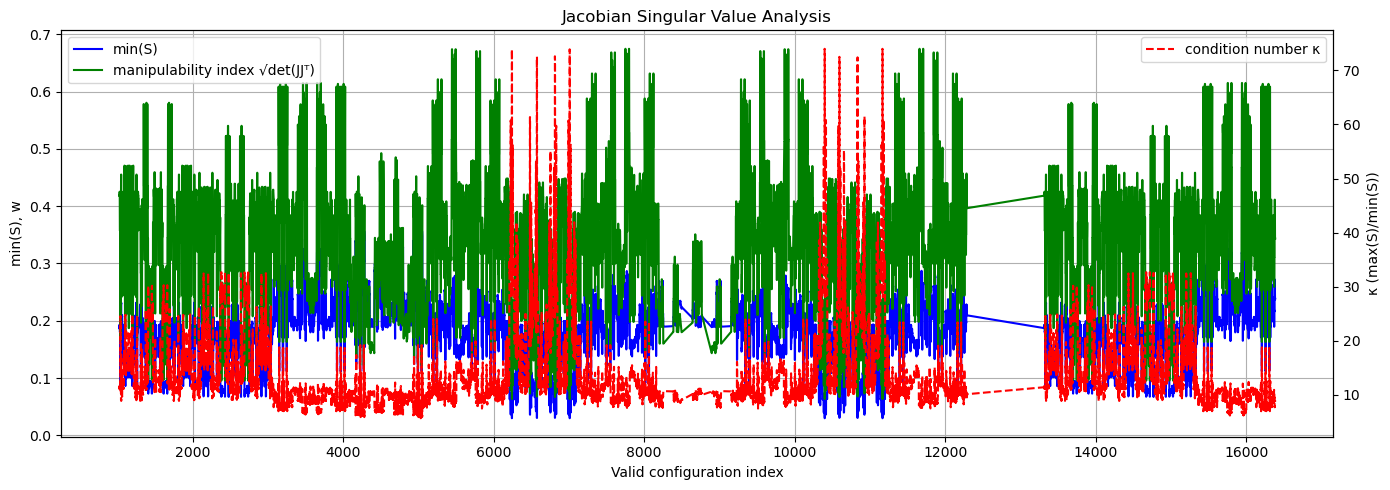

In [28]:
ee_id_r = jvrc1.model.getFrameId("right_arm_eef")
ee_id_l = jvrc1.model.getFrameId("L_WRIST_Y")
if ENABLE_RIGHT_ARM:
    plot_singularity_indicators(grid, jvrc1, ee_id_r, joint_ids_right)
if ENABLE_LEFT_ARM:
    plot_singularity_indicators(grid, jvrc1, ee_id_l, joint_ids_left)


In [29]:
def display_pointcloud_in_meshcat(viewer, name, points, color=np.array([0.1, 0.6, 1.0]), point_size=0.01):
    """Display 3D point cloud in Meshcat."""
    pts = np.vstack(points).T if isinstance(points, list) else points.T
    viewer[name].set_object(g.PointCloud(pts, color, size=point_size))

def display_convex_hull_in_meshcat(viewer, name, points, color=0xffcc00, opacity=0.5):
    """Display convex hull surface in Meshcat."""
    pts = np.vstack(points) if isinstance(points, list) else points
    hull = ConvexHull(pts)
    viewer[name].set_object(
        g.TriangularMeshGeometry(pts, hull.simplices),
        g.MeshLambertMaterial(color=color, opacity=opacity)
    )

def save_convex_hull_json(filename, hull):
    data = {"vertices": hull.points.tolist(), "faces": hull.simplices.tolist()}
    with open(filename, "w") as f:
        json.dump(data, f, indent=2)

# Save point clouds
if ENABLE_RIGHT_ARM and len(ee_positions_right) > 0:
    np.save("workspace_right.npy", np.vstack(ee_positions_right))

if ENABLE_LEFT_ARM and len(ee_positions_left) > 0:
    np.save("workspace_left.npy", np.vstack(ee_positions_left))




# === Fonctions complémentaires (matplotlib/Open3D/PyVista) ===
def show_workspace_pointcloud(points, fallback_matplotlib=True):
    try:
        import open3d as o3d
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(np.vstack(points))
        color = np.array([[0.2, 0.6, 1.0]])
        pcd.colors = o3d.utility.Vector3dVector(np.tile(color, (len(points), 1)))
        o3d.visualization.draw_geometries([pcd], window_name="Workspace Viewer")
    except ImportError:
        if fallback_matplotlib:
            from mpl_toolkits.mplot3d import Axes3D
            fig = plt.figure(figsize=(8, 8))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, c='blue', alpha=0.4)
            ax.set_title("3D Workspace Pointcloud")
            ax.set_xlabel("X [m]")
            ax.set_ylabel("Y [m]")
            ax.set_zlabel("Z [m]")
            plt.show()

def show_pointcloud_pyvista(points, point_size=5.0, color='dodgerblue'):
    pts = np.vstack(points) if isinstance(points, list) else points
    cloud = pv.PolyData(pts)
    plotter = pv.Plotter()
    plotter.add_points(cloud, color=color, point_size=point_size, render_points_as_spheres=True)
    plotter.add_axes()
    plotter.show(title="Workspace Viewer (PyVista)", window_size=[800, 800])

In [30]:
if ENABLE_RIGHT_ARM and SHOW_POINT_CLOUD:
    display_pointcloud_in_meshcat(viz.viewer, "workspace/right_arm", ee_positions_right)
if ENABLE_LEFT_ARM and SHOW_POINT_CLOUD:
    display_pointcloud_in_meshcat(viz.viewer, "workspace/left_arm", ee_positions_left)

if ENABLE_RIGHT_ARM and SHOW_CONVEX_HULL:
    display_convex_hull_in_meshcat(viz.viewer, "workspace/hull_right", ee_positions_right)
if ENABLE_LEFT_ARM and SHOW_CONVEX_HULL:
    display_convex_hull_in_meshcat(viz.viewer, "workspace/hull_left", ee_positions_left, color=0xc39bd3)


In [31]:

def display_random_configurations_from_valid_set(robot, q_list, max_display=10, delay=1.5):
    """
    Affiche aléatoirement des configurations valides déjà collectées dans Meshcat.

    Args:
        robot: RobotWrapper
        q_list: liste de configurations valides (déjà filtrées)
        max_display: nombre de configurations à afficher
        delay: temps d'attente entre affichages (en secondes)
    """
    if not q_list:
        print("[WARN] Aucune configuration valide disponible pour affichage.")
        return

    indices = list(range(len(q_list)))
    random.shuffle(indices)
    count = 0

    for i in indices:
        q = q_list[i]
        viz.display(q)
        print(f"[INFO] Displayed configuration {count+1} (index {i})")
        time.sleep(delay)
        count += 1
        if count >= max_display:
            break



In [32]:

# display_random_configurations_from_valid_set(jvrc1, q_valid, max_display=10, delay=1.0)

In [33]:
def display_ellipsoids_in_meshcat(viewer, terms, q=None, name_prefix="ellipsoids/"):
    """
    Affiche une liste d'ellipsoïdes dans Meshcat à partir de leur fonction de centre et dimensions.
    
    :param viewer: viz.viewer
    :param terms: liste de EllipsoidTerm (center_fn, axes_lengths, name)
    :param q: configuration à évaluer (np.ndarray), si None utilise q_start
    :param name_prefix: préfixe du nom dans le viewer
    """
    if q is None:
        q = pin.neutral(jvrc1.model)

    for term in terms:
        center = np.array(term.center_fn(q)).flatten()
        axes = term.axes_lengths

        ell = g.Ellipsoid(axes)
        viewer[name_prefix + term.name].set_object(
            ell, g.MeshLambertMaterial(opacity=0.3, color=0xff0000)
        )
        T = np.eye(4)
        T[:3, 3] = center
        viewer[name_prefix + term.name].set_transform(T)
def display_collision_boxes_in_meshcat(viz, model, collision_model, collision_data, name_prefix="debug/box/"):
    for i, geom in enumerate(collision_model.geometryObjects):
        if not isinstance(geom.geometry, Box):
            continue
        T = collision_data.oMg[i]  # Pose globale de l'objet de collision
        size = 2 * np.array(geom.geometry.halfSide)  # Convertir halfSide -> size complète
        box = g.Box(size)
        viz.viewer[name_prefix + geom.name].set_object(
            box, g.MeshLambertMaterial(opacity=0.2, color=0xff0000)
        )
        viz.viewer[name_prefix + geom.name].set_transform(T.homogeneous)


In [34]:
# # === Cellule 11 : Affichage de l'espace atteignable (reachable space) avec pycapacity invalid en python 3.13 (dependance cgal ===
# import pycapacity.robot as pycap
# import meshcat.geometry as g
# import time

# # Durée d'horizon pour l'analyse
# horizon_time = 0.2  # secondes

# # Fonction de cinématique directe isolée au bras droit uniquement
# def fk_arm_only(q_arm):
#     q = q0.flatten().copy()
#     q = set_arm_configuration(jvrc1, q, q_arm, joint_ids_right)
#     pin.framesForwardKinematics(jvrc1.model, jvrc1.data, q)
#     return jvrc1.data.oMf[ee_id_r].translation

# # Définition des limites spécifiques au bras droit
# ql_arm = ql[joint_ids_right]
# qu_arm = qu[joint_ids_right]
# dq_max_arm = np.ones(len(joint_ids_right)) * 1.0

# # Options de sampling de pycapacity
# opt = {
#     'calculate_faces': True,
#     'convex_hull': False,
#     'n_samples': 2,
#     'facet_dim': 1
# }

# # Trajectoire entre configurations valides (ex: ligne droite entre deux valeurs)
# q_start = (ql_arm + qu_arm) / 2 - 0.3 * (qu_arm - ql_arm)
# q_end   = (ql_arm + qu_arm) / 2 + 0.3 * (qu_arm - ql_arm)

# for alpha in np.linspace(0, 1, 50):
#     q_arm = (1 - alpha) * q_start + alpha * q_end

#     rw_poly = pycap.reachable_space_nonlinear(
#         forward_func=fk_arm_only,
#         q0=q_arm,
#         q_max=qu_arm,
#         q_min=ql_arm,
#         dq_max=dq_max_arm,
#         dq_min=-dq_max_arm,
#         time_horizon=horizon_time,
#         options=opt
#     )

#     # Visualiser le robot dans Meshcat avec la posture actuelle
#     q_full = set_arm_configuration(jvrc1, q0.flatten().copy(), q_arm, joint_ids_right)
#     q_full = set_arm_configuration(jvrc1, q_full, q_arm, joint_ids_left, mirror=True)
#     viz.display(q_full)

#     # Visualiser le polytope ou fallback en nuage de points si pas de faces
#     if hasattr(rw_poly, 'face_indices') and rw_poly.face_indices is not None and len(rw_poly.face_indices) > 0:
#         poly = g.TriangularMeshGeometry(vertices=rw_poly.vertices.T, faces=rw_poly.face_indices)
#         viz.viewer['rwspace'].set_object(poly, g.MeshBasicMaterial(color=0x0022ff, wireframe=True, linewidth=3, opacity=0.2))
#     else:
#         points = rw_poly.vertices.T
#         viz.viewer['rwspace'].set_object(g.PointCloud(points), g.PointsMaterial(size=0.01, color=0x0022ff))

#     time.sleep(0.001)
